# Projet 10 - Application finale

## Visualisation et exploration des données

In [13]:
#On importe les bibliothèques correspondantes ainsi que le module Re
import numpy as np
import pandas as pd
import seaborn as sns
import re
import datetime as dt
import scipy.stats as st
import matplotlib.pyplot as plt
import math as mth

#On importe les bibliothèques pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection
from sklearn.preprocessing import scale

#On importe les bibliothèques pour le K-Means
from sklearn.cluster import KMeans

#On importe les bibliothèques pour les régressions linéaires
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from sklearn.linear_model import LinearRegression

#On importe la bibliothèque Scikit-Learn pour les algorithmes de Machine Learning
import sklearn as sk
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

In [14]:
# On importe les données
Billet_train = pd.read_csv("billets_complet.csv")
Billet_test = pd.read_csv("billets_production.csv")

#On visualise les données
print("Informations du DataFrame billets: \n")
print(Billet_train.info())
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("Affichage du DataFrame billets: \n")
print(Billet_train.head())
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")
print("Description du DataFrame billets: \n")
print(Billet_train.describe())
print("-----------------------------------------------------------------------------")
print("-----------------------------------------------------------------------------")

Informations du DataFrame billets: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1500 non-null   int64  
 1   is_genuine    1500 non-null   bool   
 2   diagonal      1500 non-null   float64
 3   height_left   1500 non-null   float64
 4   height_right  1500 non-null   float64
 5   margin_low    1500 non-null   float64
 6   margin_up     1500 non-null   float64
 7   length        1500 non-null   float64
 8   cluster       1500 non-null   int64  
dtypes: bool(1), float64(6), int64(2)
memory usage: 95.3 KB
None
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
Affichage du DataFrame billets: 

   Unnamed: 0  is_genuine  diagonal  height_left  height_right  margin_low  \
0           0        True    171.94       103.89   

In [15]:
#On ne garde que les colonnes utiles
Billet_train = Billet_train[['is_genuine', 'diagonal', 'height_left','height_right', 'margin_low','margin_up', 'length']]
Billet_train.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.94,103.89,103.45,4.318525,3.25,112.79
1,True,171.93,104.07,104.18,4.393668,3.14,113.08
2,True,172.07,103.80,104.38,4.410457,3.02,112.93
3,True,171.45,103.66,103.80,4.319014,3.62,113.27
4,True,171.83,104.14,104.06,4.650617,3.02,112.36


In [16]:
#Affichons maintenant les données de test
Billet_test.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [17]:
#Programmation d'une fonction de détection automatique de billets à l'aide de la régression logistique

def banknote_detector(dimensions_billets_train, dimensions_billets_test):
    
    """On définit la fonction qui va prendre en entrée les données d'entraînement puis les données de test,
    et nous retournera le statut des billets ainsi que la position des billets tests par rapport aux billets d'entrainement."""
    
    #On définit les centroïdes
    dimensions_billets_train_c = dimensions_billets_train.groupby('is_genuine', as_index=False)['length','margin_low'].mean()
    ctrx1 = dimensions_billets_train_c.at[0, 'length']
    ctry1 = dimensions_billets_train_c.at[0, 'margin_low']
    ctrx2 = dimensions_billets_train_c.at[1, 'length']
    ctry2 = dimensions_billets_train_c.at[1, 'margin_low']
    
    #On convertit en index l'id des billets
    dimensions_billets_test.set_index('id', inplace=True)
    
    #Sélection des colonnes
    X = dimensions_billets_train.copy()
    X_train = X.iloc[:, 1:7]
    y_train = dimensions_billets_train.iloc[:, 0]
    
    #On entraine le modèle
    modele = LogisticRegression()
    modele.fit(X_train, y_train)
    
    #On examine et teste le modèle
    y_lr = modele.predict_proba(dimensions_billets_test)
    
    #On injecte les résultats
    dimensions_billets_test['proba_negative'] = y_lr[:,0]
    dimensions_billets_test['proba_positive'] = y_lr[:,1]
    dimensions_billets_test['detection'] = ["True (detection)" if s >=0.5 else "Counterfeit (detection)" for s in dimensions_billets_test['proba_positive']] 
    
    #On affiche les points en fonction dans le plan length et margin_low
    plt.figure(figsize=(15,8))
    
    
    
    ax = sns.scatterplot('length','margin_low', data = dimensions_billets_train, hue ='is_genuine', palette=['lightcoral', 'lightgreen'])
    ax2 = sns.scatterplot('length','margin_low', data = dimensions_billets_test, hue ='detection', palette=['darkred', 'darkgreen'])
    sns.scatterplot(x=[ctrx1], y=[ctry1], s=100, color='k')
    sns.scatterplot(x=[ctrx2], y=[ctry2], s=100, color='k')
    norm = plt.Normalize(dimensions_billets_test['proba_positive'].min(), dimensions_billets_test['proba_positive'].max())
    sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
    sm.set_array([])

    ax.get_legend()
    
    plt.title('Logistic Regression: Binary Classification')
    plt.text(110, 6,'Negative',size='large', bbox=dict(facecolor='red', alpha=0.5))
    plt.text(114, 3.5,'Positive',size='large', bbox=dict(facecolor='green', alpha=0.5))
    plt.grid(False)
    plt.show()
    
    return dimensions_billets_test

    

C:\Users\nic_9\AppData\Local\Temp/ipykernel_2280/3785397691.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dimensions_billets_train_c = dimensions_billets_train.groupby('is_genuine', as_index=False)['length','margin_low'].mean()
C:\Users\nic_9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\nic_9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


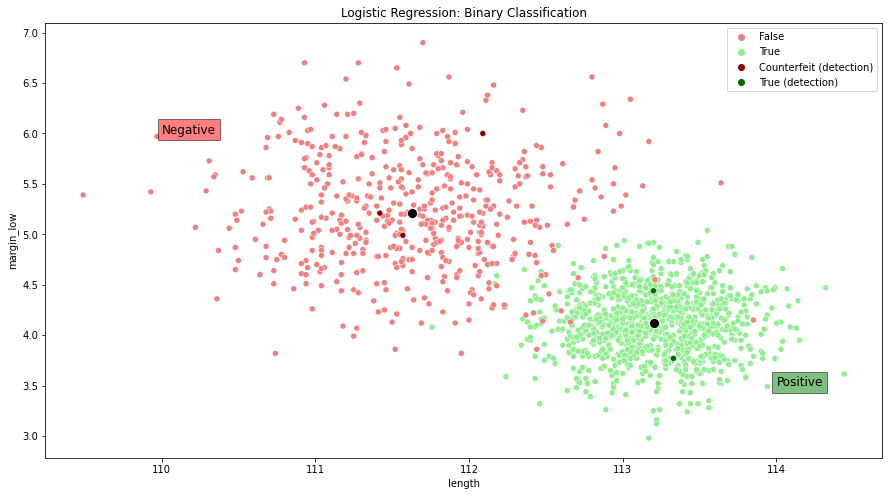

,diagonal,height_left,height_right,margin_low,margin_up,length,proba_negative,proba_positive,detection
id,,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,0.996188,0.003812,Counterfeit (detection)
A_2,171.87,104.17,104.13,6.00,3.31,112.09,0.999343,0.000657,Counterfeit (detection)
A_3,172.00,104.58,104.29,4.99,3.39,111.57,0.999058,0.000942,Counterfeit (detection)
A_4,172.49,104.55,104.34,4.44,3.03,113.20,0.076450,0.923550,True (detection)
A_5,171.65,103.63,103.56,3.77,3.16,113.33,0.000272,0.999728,True (detection)


In [18]:
banknote_detector(Billet_train, Billet_test)